# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/InformationBottleneck')
sys.path.append('/content/drive/MyDrive/MLMI_InfoBottleneck')

Mounted at /content/drive


In [3]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
    
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data and Model

### Insert the bottleneck into the model

You can experiment with the location of the bottleneck.

In [5]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'

dev = torch.device('cuda:0')
# dev = torch.device('cpu:0')

# select a model to analyse
model = torchvision.models.vgg16(pretrained=True)
# model = torchvision.models.resnet50(pretrained=True)
# model = torchvision.models.inception_v3(pretrained=True)
model.to(dev).eval()

# load the data
if type(model) == torchvision.models.inception.Inception3:
    image_size = 299
else:
    image_size = 224
    
valset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

trainset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

with open(os.path.join(prak_dir, 'imagenet_class_index.json')) as f:
    idx2class = {int(k): v[1] for k, v in json.load(f).items()}

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
img, target = valset[0]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [6]:
if type(model) == torchvision.models.vgg.VGG:
    iba = IBA(model.features[17])
elif type(model) == torchvision.models.resnet.ResNet:
    iba = IBA(model.layer2)
elif type(model) == torchvision.models.inception.Inception3:
    iba = IBA(model.Mixed_5b)

In [7]:
iba.sigma = None
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [8]:
iba.estimate(model, trainloader, device=dev, n_samples=1000, progbar=True)

In [ ]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, iba.estimator.mean()[neuron],  iba.estimator.std()[neuron]))

Neuron at position (12, 3, 4) has mean -9.71 and std 12.81


In [ ]:
iba.estimator.n_samples()

1024

In [ ]:
iba._std.shape

torch.Size([512, 28, 28])

In [ ]:
iba.estimator.std().shape

torch.Size([512, 28, 28])

## Monkey image

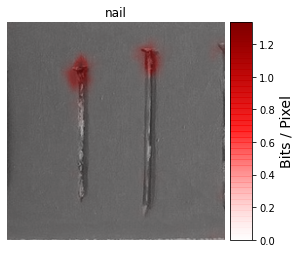

In [9]:
# img = np.array(Image.open("./monkeys.jpg"))
# img = (img.transpose(2, 0, 1) / 255)
target = 677  # 382: squirrel monkey #677 nail
# preprocess image
img  = Compose([
    CenterCrop(256),
    Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open(os.path.join(prak_dir, "nail.jpg")))
iba.reverse_lambda = False
iba.beta = 10
model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()

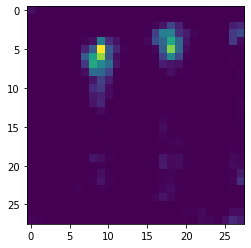

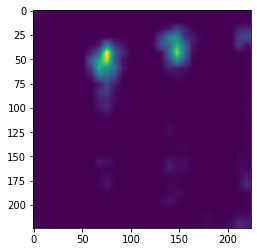

In [10]:
img_tensor_mean = iba.capacity().sum(0)
plt.figure()
plt.imshow(img_tensor_mean.clone().detach().cpu().numpy())
plt.figure()
plt.imshow(heatmap)

# GAN

In [11]:
from IBA.gan import WGAN_CP

In [12]:
# wgan = WGAN_CP(model, "layer2", 
#                image=img.to(dev), feature_mask=iba.capacity(),
#                feature_noise_mean=iba.estimator.mean(), feature_noise_std=iba.estimator.std(), dev=dev)
wgan = WGAN_CP(model, "features", 
               image=img.to(dev), feature_mask=iba.capacity(),
               feature_noise_mean=iba.estimator.mean(), feature_noise_std=iba.estimator.std(), dev=dev)

WGAN_CP init model.


In [ ]:
for batch in wgan.dataloader:
    print(batch[0].shape)

torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([32, 512, 28, 28])
torch.Size([12, 512, 28, 28])


In [13]:
wgan.train(dev)

[Epoch 0/200] [Batch 0/25] [D loss: -0.022771] [G loss: -0.007511]
[Epoch 0/200] [Batch 5/25] [D loss: -0.014589] [G loss: -0.002350]
[Epoch 0/200] [Batch 10/25] [D loss: -0.028842] [G loss: 0.005685]
[Epoch 0/200] [Batch 15/25] [D loss: -0.053930] [G loss: 0.020297]
[Epoch 0/200] [Batch 20/25] [D loss: -0.099268] [G loss: 0.046595]
[Epoch 1/200] [Batch 0/25] [D loss: -0.176804] [G loss: 0.089496]
[Epoch 1/200] [Batch 5/25] [D loss: -0.301638] [G loss: 0.154790]
[Epoch 1/200] [Batch 10/25] [D loss: -0.490428] [G loss: 0.250838]
[Epoch 1/200] [Batch 15/25] [D loss: -0.755437] [G loss: 0.381425]
[Epoch 1/200] [Batch 20/25] [D loss: -1.085619] [G loss: 0.538064]
[Epoch 2/200] [Batch 0/25] [D loss: -1.461108] [G loss: 0.713558]
[Epoch 2/200] [Batch 5/25] [D loss: -1.872851] [G loss: 0.905027]
[Epoch 2/200] [Batch 10/25] [D loss: -2.312589] [G loss: 1.111235]
[Epoch 2/200] [Batch 15/25] [D loss: -2.785216] [G loss: 1.326498]
[Epoch 2/200] [Batch 20/25] [D loss: -3.293260] [G loss: 1.558231]

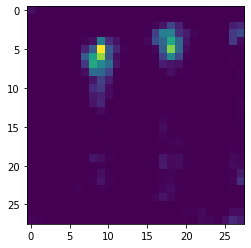

In [14]:
img_tensor_mean = iba.capacity().sum(0)
plt.figure()
plt.imshow(img_tensor_mean.clone().detach().cpu().numpy())


In [15]:
class _SpatialGaussianKernel(nn.Module):
    """ A simple convolutional layer with fixed gaussian kernels, used to smoothen the input """
    def __init__(self, kernel_size, sigma, channels,):
        super().__init__()
        self.sigma = sigma
        self.kernel_size = kernel_size
        assert kernel_size % 2 == 1, \
            "kernel_size must be an odd number (for padding), {} given".format(self.kernel_size)
        variance = sigma ** 2.
        x_cord = torch.arange(kernel_size, dtype=torch.float)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1)
        mean_xy = (kernel_size - 1) / 2.
        kernel_2d = (1. / (2. * np.pi * variance)) * torch.exp(
            -torch.sum((xy_grid - mean_xy) ** 2., dim=-1) /
            (2 * variance)
        )
        kernel_2d = kernel_2d / kernel_2d.sum()
        kernel_3d = kernel_2d.expand(channels, 1, -1, -1)  # expand in channel dimension
        self.conv = nn.Conv2d(in_channels=channels, out_channels=channels,
                              padding=0, kernel_size=kernel_size,
                              groups=channels, bias=False)
        self.conv.weight.data.copy_(kernel_3d)
        self.conv.weight.requires_grad = False
        self.pad = nn.ReflectionPad2d(int((kernel_size - 1) / 2))

    def parameters(self, **kwargs):
        """returns no parameters"""
        return []

    def forward(self, x):
        return self.conv(self.pad(x))

0.5101286


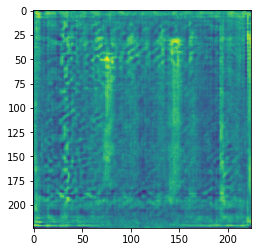

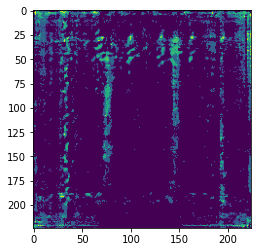

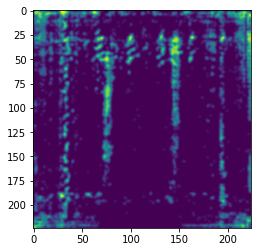

In [24]:
# img_tensor = wgan.G.image_mask().detach().cpu().numpy()
img_tensor = wgan.G.image_mask().clone().detach().cpu().numpy()
# print(wgan.G.mean)
# print(wgan.G.eps)
print(img_tensor.mean())
# img_tensor = img_tensor.mean(0).mean(0)
img_tensor = img_tensor.mean(0)[2]
plt.imshow(img_tensor)
z = np.copy(wgan.G.image_mask().clone().detach().cpu().numpy())
z[z<0.6] = 0
plt.figure()
plt.imshow(z.mean(0).mean(0))
kernel = _SpatialGaussianKernel(int(round(2 * 1)) * 2 + 1 , 1, 3).to(dev)
z_smooth = kernel(torch.tensor(z).to(dev))
z_smooth = z_smooth.detach().cpu().numpy()
plt.figure()
plt.imshow(z_smooth.mean(0).mean(0))

In [17]:
for masks in wgan.image_mask_history:
  img_tensor = masks.mean(0).mean(0)
  plt.imshow(img_tensor) 
  plt.figure()
  plt.imshow(img_tensor)
  # print(wgan.D(imgs))

Output hidden; open in https://colab.research.google.com to view.

(512, 28, 28)


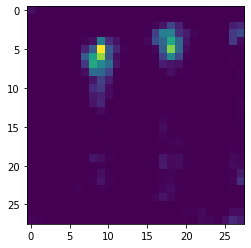

In [18]:
# img_tensor = wgan.G.image_mask().detach().cpu().numpy()
img_tensor = wgan.feature_mask.clone().detach().cpu().numpy()

print(img_tensor.shape)
img_tensor = img_tensor.mean(0)
plt.imshow(img_tensor)

(10, 512, 28, 28)


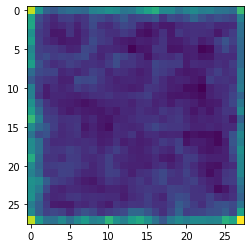

In [22]:
z = torch.zeros_like(wgan.image)
z = z.unsqueeze(0).expand(10, -1, -1, -1).clone().normal_().to(dev)

# Generate a batch of images
fake_imgs = wgan.G(z).clone().detach().cpu().numpy()

print(fake_imgs.shape)
img_tensor = fake_imgs[0].mean(0)
plt.imshow(img_tensor)

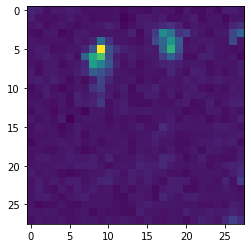

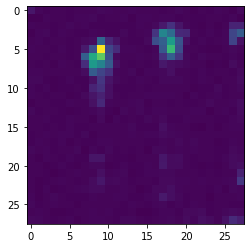

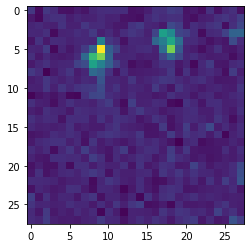

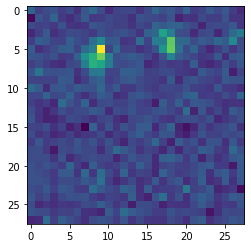

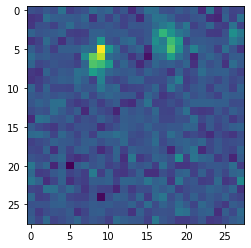

In [20]:
imgs = next(iter(wgan.dataloader))
imgs = imgs[0]
img_tensor = imgs[0].clone().detach().cpu().numpy().mean(0)
plt.imshow(img_tensor)
# print(wgan.D(imgs))
imgs = next(iter(wgan.dataloader))
imgs = imgs[0]
img_tensor = imgs[0].clone().detach().cpu().numpy().mean(0)
plt.figure()
plt.imshow(img_tensor)
imgs = next(iter(wgan.dataloader))
imgs = imgs[0]
img_tensor = imgs[0].clone().detach().cpu().numpy().mean(0)
plt.figure()
plt.imshow(img_tensor)
imgs = next(iter(wgan.dataloader))
imgs = imgs[0]
img_tensor = imgs[0].clone().detach().cpu().numpy().mean(0)
plt.figure()
plt.imshow(img_tensor)
imgs = next(iter(wgan.dataloader))
imgs = imgs[0]
img_tensor = imgs[0].clone().detach().cpu().numpy().mean(0)
plt.figure()
plt.imshow(img_tensor)

In [ ]:
z = torch.zeros_like(wgan.image)
z = z.unsqueeze(0).expand(10, -1, -1, -1).clone().normal_().to(dev)

# Generate a batch of images
fake_imgs = wgan.G(z).clone().detach().cpu().numpy()

print(wgan.D(wgan.G(z)))

tensor([[-208.0137],
        [-209.4059],
        [-207.9274],
        [-207.7670],
        [-210.2110],
        [-210.0699],
        [-208.4592],
        [-208.1904],
        [-209.7630],
        [-209.3802]], device='cuda:0', grad_fn=<AddmmBackward>)
